In [18]:
pip install yfinance numpy pandas statsmodels matplotlib hurst

Note: you may need to restart the kernel to use updated packages.


In [19]:
# Setup
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from hurst import compute_Hc

# Definitions
# Definition of half-life: the time required for a quantity (of substance) to reduce to half of its initial value.
# Definition of volatility: a statistical measure of the dispersion of returns for a given security or market index.

In [20]:
# Step 1: Data Import
# Download historical data for Class III Milk futures (symbol: DC=F)
data = yf.download('DC=F', start='2020-01-01', end='2024-05-01', interval='1d')
data = data['Adj Close'].dropna()

# Log prices
log_prices = np.log(data)
print("Log Prices Head:\n", log_prices.head())

# Calculate daily returns
returns = log_prices.diff().dropna()
print("Returns Head:\n", returns.head())

[*********************100%%**********************]  1 of 1 completed

Log Prices Head:
 Date
2020-01-02    2.963726
2020-01-03    2.829087
2020-01-06    2.831447
2020-01-07    2.839078
2020-01-08    2.833213
Name: Adj Close, dtype: float64
Returns Head:
 Date
2020-01-03   -0.134638
2020-01-06    0.002360
2020-01-07    0.007631
2020-01-08   -0.005865
2020-01-09   -0.002945
Name: Adj Close, dtype: float64


In [21]:
# Step 2: Perform Statistical Tests
# ADF Test
adf_result = adfuller(log_prices)
adf_statistic = adf_result[0]
adf_p_value = adf_result[1]
print(f"ADF Statistic: {adf_statistic}, ADF p-value: {adf_p_value}")

# Calculate the Hurst exponent
hurst_exponent, c, data_reg = compute_Hc(log_prices)
print(f"Hurst Exponent: {hurst_exponent}")

ADF Statistic: -2.832925078602377, ADF p-value: 0.05372238713125841
Hurst Exponent: 0.43611772891089745


Smoothed Mean Reversion Rate: -0.03402135742535804
                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.503
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.115
Time:                        17:16:59   Log-Likelihood:                 483.16
No. Observations:                 200   AIC:                            -962.3
Df Residuals:                     198   BIC:                            -955.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

,Current Price,Mean Reversion Rate,Smoothed Mean Reversion Rate,Long-Run Mean,Smoother Long-Run Mean,Half-Life (in days),ADF Statistic,ADF p-value,Hurst Exponent,Deviation from SLRM
0,16.77,-0.0359,-0.034021,16.177813,17.07258,20.373884,-2.832925,0.053722,0.436118,0.592187


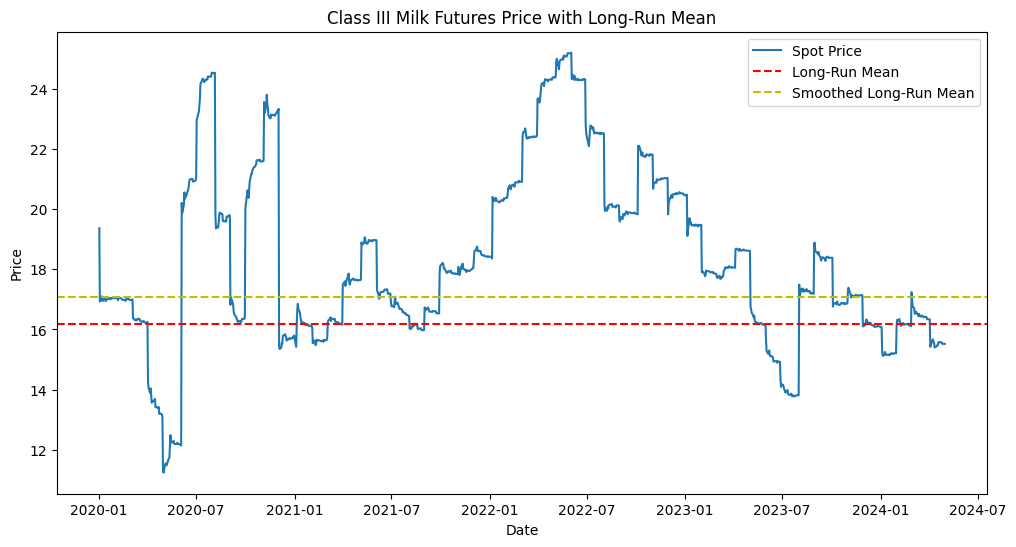

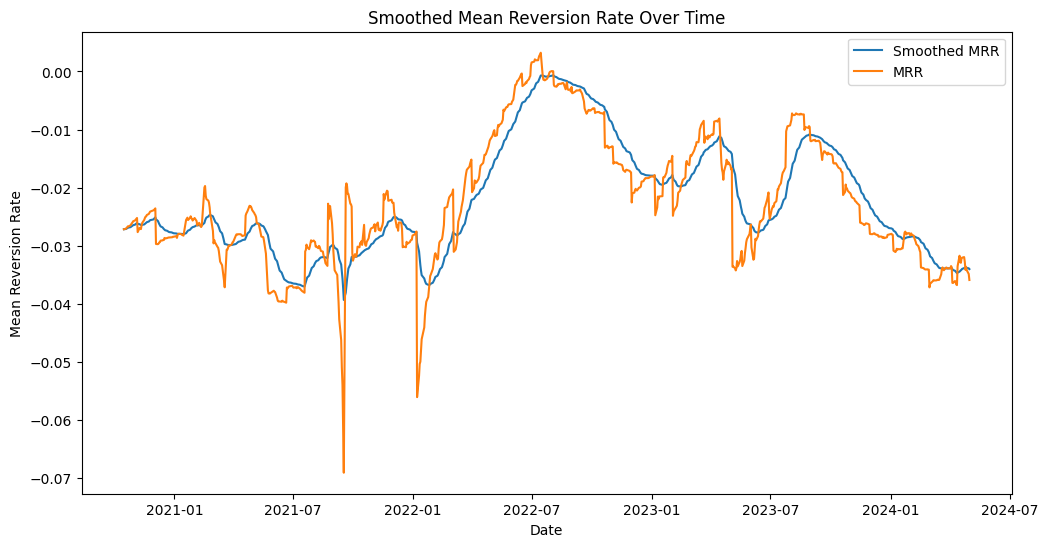

In [22]:
# Step 3: Calculate Mean Reversion Metrics if the series is mean-reverting
if hurst_exponent < 0.5:
    # Parameters
    window_size = 200  # Rolling window size for regression
    ewma_span = 30  # Span for EWMA of MRR

    # Calculate MRR over rolling windows
    mrr_values = []
    
    for start in range(len(log_prices) - window_size):
        end = start + window_size
        window_log_prices = log_prices[start:end]
        window_returns = returns[start + 1:end + 1]  # Align the returns to the same window
        
        # Ensure the indices are aligned
        common_index = window_log_prices.index.intersection(window_returns.index)
        window_log_prices = window_log_prices.loc[common_index]
        window_returns = window_returns.loc[common_index]
        
        if len(window_log_prices) != len(window_returns):
            continue  # Skip if we still have misalignment

        X = sm.add_constant(window_log_prices)
        Y = window_returns
        
        model = sm.OLS(Y, X).fit()
        alpha = model.params.iloc[1]
        intercept_mrr = model.params.iloc[0]
        mrr = -alpha  # Mean reversion rate is the negative slope
        mrr_values.append(mrr)

    # Convert MRR values to a Series
    mrr_series = pd.Series(mrr_values, index=log_prices.index[window_size:window_size+len(mrr_values)])

    # Apply EWMA to the MRR values
    smoothed_mrr = mrr_series.ewm(span=ewma_span).mean()

    # Use the last smoothed MRR value
    mean_reversion_rate = smoothed_mrr.iloc[-1]
    print(f"Smoothed Mean Reversion Rate: {mean_reversion_rate}")

    # Calculate the intercept from the last window
    window_log_prices = log_prices[-window_size:]
    window_returns = returns[-window_size:]
    common_index = window_log_prices.index.intersection(window_returns.index)
    window_log_prices = window_log_prices.loc[common_index]
    window_returns = window_returns.loc[common_index]

    X = sm.add_constant(window_log_prices)
    Y = window_returns

    model = sm.OLS(Y, X).fit()
    intercept = model.params.iloc[0]
    print(model.summary())

    # Calculate Long-Run Mean (LRM)
    print("\nIntercept is ", intercept)
    print("\nMRR is ", mrr)
    long_run_mean = np.exp(intercept_mrr / mrr)
    print("\nLong Run Mean is ", long_run_mean)
    smoothed_long_run_mean = np.exp(intercept / mean_reversion_rate)
    print("\nSmoothed Long Run Mean is ", smoothed_long_run_mean)

    # Calculate Half-Life
    if mean_reversion_rate != 0:
        half_life = np.log(2) / abs(mean_reversion_rate)
    else:
        half_life = np.nan

    # Step 4: Assess Current Price Relative to LRM
    # Current price as of 1 March 2024 or the last available date
    date_to_check = '2024-03-01'
    if date_to_check in data.index:
        current_price = data.loc[date_to_check]
    else:
        current_price = data.iloc[-1]  # Last available date
        print(f"\nDate {date_to_check} not found. Using the last available date: {data.index[-1]}")

    # Assess whether the current price is far from the LRM
    deviation_from_lrm = current_price - long_run_mean
    print(f"Current Price: {current_price}, Deviation from LRM: {deviation_from_lrm}")

    # Step 5: Display Results and Plots
    # Display results
    values = {
        'Current Price': current_price,
        'Mean Reversion Rate': mrr,
        'Smoothed Mean Reversion Rate': mean_reversion_rate,
        'Long-Run Mean': long_run_mean,
        'Smoother Long-Run Mean': smoothed_long_run_mean,
        'Half-Life (in days)': half_life,
        'ADF Statistic': adf_statistic,
        'ADF p-value': adf_p_value,
        'Hurst Exponent': hurst_exponent,
        'Deviation from SLRM': deviation_from_lrm
    }
    print("Calculated Values:\n", values)

    # Display results
    values_df = pd.DataFrame(values, index=[0])
    display(values_df)

    # Plotting the data, MRR, and long-run mean
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data, label='Spot Price')
    plt.axhline(y=long_run_mean, color='r', linestyle='--', label='Long-Run Mean')
    plt.axhline(y=smoothed_long_run_mean, color='y', linestyle='--', label='Smoothed Long-Run Mean')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Class III Milk Futures Price with Long-Run Mean')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(smoothed_mrr.index, smoothed_mrr, label='Smoothed MRR')
    plt.plot(mrr_series.index, mrr_series, label='MRR')
    plt.xlabel('Date')
    plt.ylabel('Mean Reversion Rate')
    plt.title('Smoothed Mean Reversion Rate Over Time')
    plt.legend()
    plt.show()
else:
    print("The time series does not exhibit mean reversion based on the ADF test and Hurst exponent.")